In [124]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import importlib
from modules import base_model as bm 
from modules import obstacles as obs
from modules import run_simulation
from modules import attractor as att

importlib.reload(bm); importlib.reload(obs); importlib.reload(run_simulation); importlib.reload(att)
print(f'Imported modules successfully!')

Imported modules successfully!


In [125]:
# Just for testing lists 
obstacle_params = [[1, 2, 3, 4], [2, 3, 4, 55], [3]] 

if not(all(isinstance(i, list) for i in obstacle_params)):
        # If it's just a list, make it a list of lists.
        print(f'Changing.')
        obstacle_params = np.array([obstacle_params])

obstacle_params

[[1, 2, 3, 4], [2, 3, 4, 55], [3]]

#### After meeting on 24/11:
Flossie to look at real world data. Maybe start the writing.<br>
Colm to do the qualitative/quantitative success rates.<br>
Ruby to incorporate her wind into the obstacle version.

I will:
- Introduce a 'steer-to-avoid' version.
- Find a way to have the obstacles remove birds from the system.

In [126]:
# v0, eta, L, dt, Nt, N
model_params = [0.3, 0.6, 10, 0.2, 200, 100]

# lam_c, lam_a, lam_m, lam_att, A, R.
strength_params = [0.2, 0.8, 0.4, 0.2, 0.15, 1.25]

# As many obstacle params as we can without overlapping
lam_o = 1
O_rad = 1.25

obstacle_params = np.array([
 [lam_o, 1.5, 1.5, O_rad],
 [lam_o, 1.5, 4.5, O_rad],
 [lam_o, 1.5, 7.5, O_rad],

 [lam_o, 4.5, 3.0, O_rad],
 [lam_o, 4.5, 6.0, O_rad],
 [lam_o, 4.5, 9.0, O_rad],

 [lam_o, 7.5, 1.5, O_rad],
 [lam_o, 7.5, 4.5, O_rad],
 [lam_o, 7.5, 7.5, O_rad]
])

attractor_pos = np.array([15, 6])

# Let's scale everything by ? for the fun of it?
scale = 1
model_params[2] = model_params[2] * scale
obstacle_params[:, 1] *= scale
obstacle_params[:, 2] *= scale
attractor_pos = attractor_pos * scale


# run_simulation.plot_simulation_att(model_params, strength_params, obstacle_params, attractor_pos, init_left = True)
# See markdown comments.

### Scaling concerns.
A lot of the neighbourhood radii, say the 'too-close' radius or the 'neighbour' radius, has hard coded values. <br>
If increasing $L$, look to increase these too.

---

### Steer-to-avoid.
Just need to change `avoid_obstacle` in `obstacles.py`. Will need to give the function the velocity arguments, maybe also $L$.

Idea: for each obstacle, have the bird scan the space ahead of it to see if its current trajectory is going to crash. Can do something like $$\text{pred\_trajec} = \{\alpha(vx + vy) : \alpha \in [0, ~\alpha_{\max}]\}$$
to compute points on the predicted trajectory. These points can then be checked against the obstacle radii for each obstacle. If there is a point within the obstacle, update the velocity (perhaps also inverse-square proportionally to the centre). Should break on the first trajectory that matches.

In [127]:
# v0, eta, L, dt, Nt, N
model_params = [0.3, 0.6, 10, 0.2, 270, 50]
attractor_pos = [15, 2]

# run_simulation.plot_simulation_att(model_params, strength_params, obstacle_params, 
#                        attractor_pos, init_left = True, obs_method = "steer2avoid")

---

**Cathal's tests** (`Cathal Project 2.ipynb`) suggest that the three-corner obstacle pattern is the worst, and the linear barrier pattern the best. These are

$$
  [1, 2, 5, 1], [1, 5, 5, 1], [1, 8, 5, 1], \qquad  [1, 1, 1, 1], [1, 1, 9, 1], [1, 9, 1, 1]~.
$$

We can simulate these for forcefield or steer to avoid.

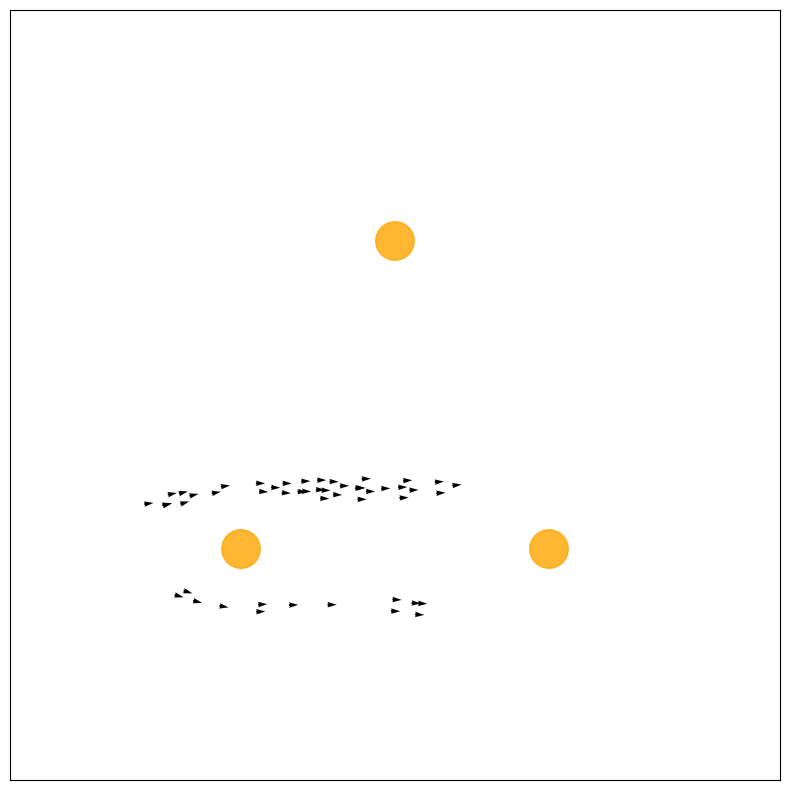

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [128]:
# List of lists.
# Each individual list is a list of obstacle paramars.
# Each obstacle param is lam_o, x, y, O.

configs = [
    # Linear barrier patterns
    [[1, 2, 5, 1], [1, 5, 5, 1], [1, 8, 5, 1]],  # Horizontal line
    [[1, 5, 2, 1], [1, 5, 5, 1], [1, 5, 8, 1]],  # Vertical line
    
    # Diagonal patterns
    [[1, 2, 2, 1], [1, 5, 5, 1], [1, 8, 8, 1]],  # Main diagonal
    [[1, 8, 2, 1], [1, 5, 5, 1], [1, 2, 8, 1]],  # Anti-diagonal
    
    # Corner protection
    [[1, 1, 1, 1], [1, 1, 9, 1], [1, 9, 1, 1]],  # Three corners
    [[1, 9, 9, 1], [1, 1, 9, 1], [1, 9, 1, 1]],  # All corners
    
    # Central clustering
    [[1, 4, 4, 1], [1, 5, 5, 1], [1, 6, 6, 1]],  # Tight cluster
    [[1, 3, 3, 1], [1, 5, 7, 1], [1, 7, 3, 1]],  # Spread but balanced
]

horizontal_obs = configs[0]
three_corner_obs = configs[5]
tight_cluster_obs = configs[6]
balanced_spread_cluster_obs = configs[-1]

attractor_pos = [15, 3]

# RUN FOR STEER2AVOID 

run_simulation.plot_simulation_att(model_params, strength_params, balanced_spread_cluster_obs, 
                        attractor_pos, init_left = True, obs_method = "steer2avoid")

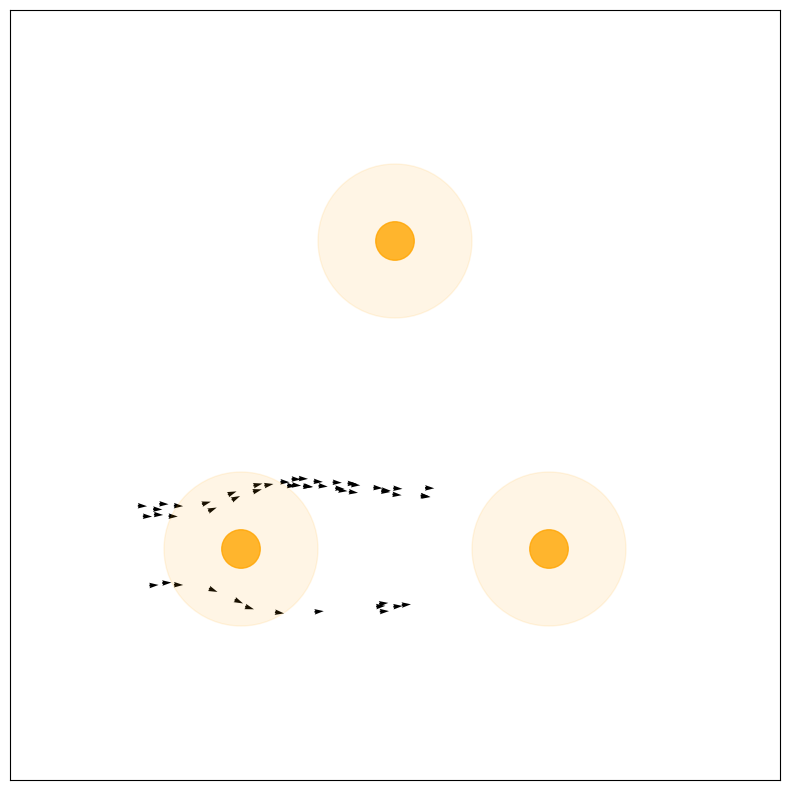

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [129]:
# RUN FOR FORCEFIELD

run_simulation.plot_simulation_att(model_params, strength_params, balanced_spread_cluster_obs, 
                        attractor_pos, init_left = True, obs_method = "forcefield")

**Some comments on these simulations.** The attractor position is rigged up to be on the same $y$-level as the bottom two obstacles. Thus the birds are incentivised to travel along that straight line $y = 3$.

With `forcefield` obstacle avoidance, the birds largely do this. Only when they are very close to the obstacle do they swerve away. With `steer2avoid`, the birds form much more consistent flight patterns, abruptly swerving far less often than in `forcefield`.

---

### Incorporating Wind
Based on the work from Ruby.

Wind affects the birds in two ways - drift or directional. For drift, you need to break it down into the $x$ and $y$ components. For directional, update each $x$ and $y$ proportional to the strength.

Parameters: `drift_wind, w_vx, w_vy, dir_wind, wind_theta, lam_w`.

Copied eveything into a new file `freds.py`.

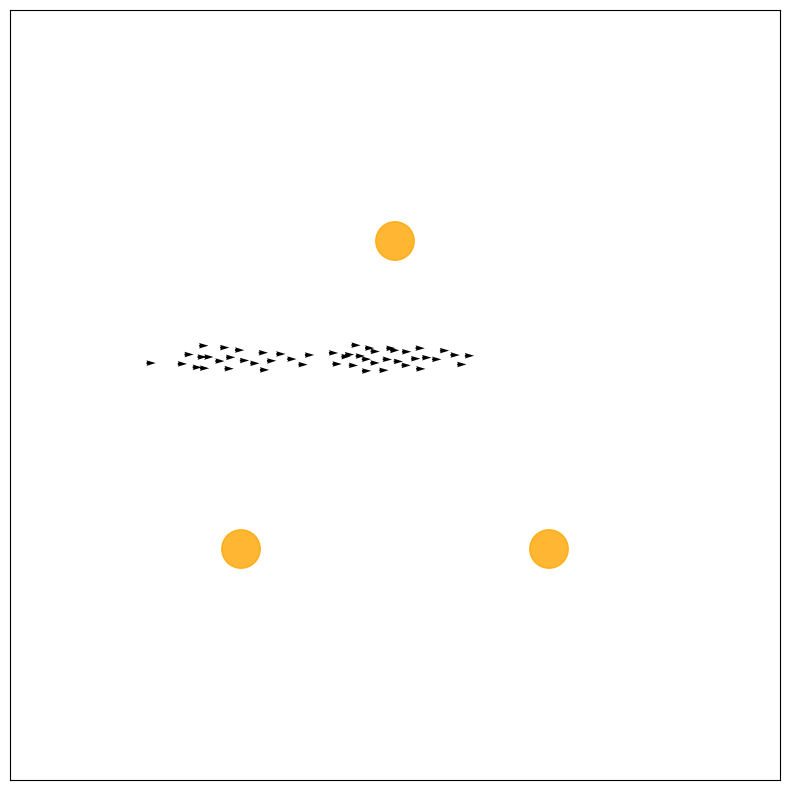

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [ ]:
from modules import freds as sim 
importlib.reload(sim);


# v0, eta, L, dt, Nt, N = model_params
model_params = [0.3, 0.6, 10, 0.2, 270, 50]

# lam_c, lam_a, lam_m, lam_att, A, R = strength_params 
strength_params = [0.2, 0.8, 0.4, 0.2, 0.15, 1.25]

# Balanced spread
obstacle_params = configs[-1]
attractor_pos = [15, 3]

wind_params = [True, 0, 0.5, False, 0, 0]

sim.plot_simulation(model_params, strength_params, obstacle_params, wind_params, 
                    attractor_pos = attractor_pos, obs_method = "steer2avoid")